<a href="https://colab.research.google.com/github/MangoGrove/MangoGrove.github.io/blob/main/Practicals/Practical2/Practical_2_Multiclass_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 40868: Neural Networks - Spring 2025

## Practical Session 2 - Wine Classification with a Fully Connected Neural Network in PyTorch

Author: Benjamin Sporrer

_New: February 10, 2025_

Logistics:
 * Using the "File > Save to Github" menu above, save a copy of this notebook to your class Github repo. Maks sure you save it  in the `Practicals/Practical2` folder by prepending `Practicals/Practical2/` to the notebook file name.
 * Study and run the notebook *before class on February 10*.
 * Arrive in class ready to do some of the work required.
 * Finish up your work and commit the changes to your repo, and finish the work by 11:59pm on Monday, February 10th.

# Provided material

## 1. Import

If you add additional imports put them here.

In [1]:
## Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

## 2. Set Device

In [2]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Load the dataset

The dataset is available from the UCI Machine Learning Repository.

It consists of 13 numerical features related to different wine attributes, and a target variable representing the wine class (1, 2, or 3). Here, the class corresponds to the cultivar (grape plant family) used in wine production.

For additional information please see the offical dataset [webpage](https://archive.ics.uci.edu/dataset/109/wine).

In [3]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
data = pd.read_csv(url, header=None)

# Print sample data before processing
print("Sample raw data:")
print(data.head())

Sample raw data:
   0      1     2     3     4    5     6     7     8     9     10    11    12  \
0   1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29  5.64  1.04  3.92   
1   1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
2   1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
3   1  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
4   1  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82  4.32  1.04  2.93   

     13  
0  1065  
1  1050  
2  1185  
3  1480  
4   735  


## 4. Extract features and labels

Features: The dataset contains 13 chemical attributes of wine.

Labels: The first column represents the wine class (1, 2, or 3).

In [4]:
# Create X and y variable to store the features and labels
X = data.iloc[:, 1:].values  # Extract all columns except the first as features
y = data.iloc[:, 0].values   # Extract the first column as labels

# Print size and examples
print("Features (X) shape:", X.shape)  # Should be (178, 13)
print("Labels (y) shape:", y.shape)    # Should be (178,)

# Print some examples
print("\nFirst  rows of Features (X):\n", X[:5])
print("\nFirst 5 Labels (y):\n", y[:5])

# Check to ensure y variable includes all of the expected labels
print("\nUnique Labels (y):\n", set(y))

Features (X) shape: (178, 13)
Labels (y) shape: (178,)

First  rows of Features (X):
 [[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
 [1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
  2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
 [1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
  3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]]

First 5 Labels (y):
 [1 1 1 1 1]

Unique Labels (y):
 {1, 2, 3}


## 5. Encode labels

In [5]:
# Since the labels are 1, 2, or 3, we need to convert them into zero-based indices (0, 1, 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Print some examples
print("\nFirst 5 Labels (y):\n", y[:5])

# Check to ensure y variable includes all of the expected labels (Now 0, 1, 2)
print("\nUnique Labels (y):\n", set(y))


First 5 Labels (y):
 [0 0 0 0 0]

Unique Labels (y):
 {0, 1, 2}


## 6. Split into training and testing datasets

We allocate 80% of the data for training and 20% for testing.

In [6]:
# The random_state parameter ensures that the split is reproducible. Without random_state, you will get different splits each time. With random_state=42, the split remains the same every time you run the code.

# The stratify=y argument ensures that the class distribution in the training and test sets is the same as in the original dataset.
# For example, if the dataset has 50% class 1, 30% class 2, and 20% class 3, then both the training and testing sets will maintain the same proportions.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 7. Standardize features

In [7]:
# Neural networks perform better with normalized inputs, so we use StandardScaler to transform each feature to have zero mean and unit variance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print sample data after preprocessing
print("\nSample processed data:")
print(pd.DataFrame(X_train).head())


Sample processed data:
         0         1         2         3         4         5         6   \
0  0.385801 -0.637871  1.776668 -1.224532  0.696430  0.526865  0.732292   
1  0.948519 -0.765445  1.253174  0.853284  0.091785  1.172795  1.333181   
2  0.523354 -0.519409  0.954034 -1.046433 -0.445678  0.930572  1.006382   
3  0.973529 -0.555859  0.168793 -1.076116 -0.714409  0.526865  0.816627   
4  0.435820  0.820120  0.056615  0.556453 -0.512860 -0.555068 -1.291756   

         7         8         9         10        11        12  
0 -0.169549 -0.415783 -0.167467  0.624378  0.252908  0.467725  
1 -0.590457  1.349742  0.305303  1.067155  0.151048  1.815768  
2 -0.169549 -0.260002 -0.081509 -0.128343  0.893172  1.516203  
3 -0.590457  0.363125  0.262324  0.890044  0.427526  1.932265  
4  0.756449 -0.606183  1.474335 -1.766619 -1.435059 -0.297831  


## 8. Convert data to PyTorch tensors

In order to utilize a GPU you must remember to move the tensor to the devivce.

In [8]:
# PyTorch models require inputs as tensors, so we convert our NumPy arrays.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

## 9. Create DataLoaders Function

Note the use of the shuffle parameter.

### shuffle=True

*   **Randomizing Order**: It ensures that the data samples are not fed into the model in the same order during each epoch. This helps in reducing bias in learning.
*   **Better Generalization**: Shuffling prevents the model from memorizing the order of data, improving its ability to generalize to unseen data.
*   **Prevents Overfitting**: If the data is ordered (e.g., all samples of one class are together), the model may learn patterns specific to that order instead of actual data features.
*   **Use During Training**: Always recommended, as it helps in breaking any potential order dependencies.

### shuffle=False:

*   **Use During Validation/Test**: Generally set to False because you want consistent evaluation results.


In [9]:
def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    """
    Creates DataLoaders for training and testing datasets.

    Args:
        X_train (torch.Tensor): Training features tensor.
        y_train (torch.Tensor): Training labels tensor.
        X_test (torch.Tensor): Test features tensor.
        y_test (torch.Tensor): Test labels tensor.
        batch_size (int): Batch size for DataLoader.

    Returns:
        tuple: (train_loader, test_loader)
    """
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

## 10. Define the Fully Connected Neural Network (FCNN)

The model consists of an input layer, one hidden layer with ReLU activation, and an output layer with the number of classes.

In [10]:
class WineClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.relu = nn.ReLU()  # Activation function (ReLU helps introduce non-linearity)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and activation
        x = self.fc2(x)  # Output layer (no activation since we will use CrossEntropyLoss)
        return x

## 11. Define Loss Function and Optimizer


### Cross-Entropy Loss

This model anticipates and is structured to use Cross Entropy Loss. This loss is typical for multi-class classification, because it penalizes incorrect confidence well. If the model assigns a low probability to the correct class, the loss is high. Addtionally, if the model is overconfident but wrong, it is severely penalized.

Cross-Entropy requires raw logits as input, so there is no activation function after the second fully connected layer in our model. It doesn't need one because it applies softmax internally to compute class probabilities.

In [11]:
# CrossEntropyLoss is used for multi-class classification.

criterion = nn.CrossEntropyLoss()

# We establish a list to house the optimizer names we plan to use. In this provided example we are only using "Adam", which is chosen for adaptive learning rate optiization.
optimizer_names = ["Adam"]

# This function is designed to create optimizers dynamically.
# If you create optimizers before defining the model, they won’t have valid parameters.
# By using lambdas, each optimizer gets initialized after the model is created.
def get_optimizer(name, model, learning_rate):
    optimizers = {
        "Adam": lambda: optim.Adam(model.parameters(), lr=learning_rate)
    }
    return optimizers.get(name, lambda: None)()  # Returns None if name is invalid

## 11. Create the training function

### Progress Bar

It is good practice to utilize a progress bar via `tqdm` when training neural networks. Here I commented the progress bar out because the the training is extremely fast due to the size of the data. With only nine batches per epoch the progress bar completes almost instantly and thus is unnecessary. Instead the model logs the loss at every ttenth interval.

### Moving Batches to the GPU

Note that PyTorch's `DataLoader` creates new batches on the fly. This means that even though we moved the entire dataset to the GPU above that the batches loaded dynamically are not automatically on the GPU. To avoid device errors make sure to always move the batches to the GPU as well as the dataset.

In [12]:
def train_model(model, train_loader, criterion, optimizer, epochs=50, log_interval=10):
    """
    Trains a PyTorch model.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        epochs (int, optional): Number of training epochs. Defaults to variable establish in future block.
        log_interval (int, optional): Frequency (in epochs) of printing the loss. Defaults to 10.

    Returns:
        list: Training loss history over epochs.
    """
    losses = []  # Store loss for visualization

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        # Create a progress bar for training using tqdm
        #progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        #for batch_x, batch_y in progress_bar: # Commented out, but this would be the needed syntax when utilizing a progeress bar

        for batch_X, batch_y in train_loader:  # Loop through mini-batches
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU
            optimizer.zero_grad()  # Reset gradients from the previous step
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update weights using optimizer
            total_loss += loss.item()  # Accumulate loss

        epoch_loss = total_loss / len(train_loader)
        losses.append(epoch_loss)  # Store loss value

        #progress_bar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{optimizer.param_groups[0]['lr']:.6f}", refresh=True)

        if (epoch + 1) % log_interval == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Plot training loss
    plt.plot(range(1, epochs+1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

    return losses

## 12. Creating the Evaluation Function

### Moving Batches to the GPU

Just like during training it is important to remember to move the batches to the GPU.

In [14]:
def evaluate_model(model, test_loader, num_samples=5):
    """
    Evaluates the model on a test dataset.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
        num_samples (int, optional): Number of sample predictions to display. Defaults to 5.

    Returns:
        float: Test accuracy in percentage.
        list: Sample outputs containing tuples of (actual_labels, predicted_labels).
    """
    model.eval()
    correct = 0
    total = 0
    sample_outputs = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU
            outputs = model(batch_X)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            total += batch_y.size(0)  # Count total samples
            correct += (predicted == batch_y).sum().item()  # Count correct predictions

            # Collect all individual samples
            sample_outputs.extend(zip(batch_y.tolist(), predicted.tolist()))

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

    # Show individual predictions
    print("\nSample evaluation results:")
    for actual, pred in sample_outputs[:num_samples]:  # Only display `num_samples`
        print(f"Actual: {actual}, Predicted: {pred}")

    return accuracy, sample_outputs

## 13. Set Model Hyperparameters

In [15]:
## Set model parameters

input_dim = X.shape[1]  # Number of features (13)
hidden_dim = 32  # Number of neurons in the hidden layer (adjustable hyperparameter)
output_dim = len(np.unique(y))  # Number of unique wine classes (3)
num_epochs = 50  # The number of times the model will pass through the dataset (adjustable hyperparameter)
batch_size = 16  # Number of images per training batch
learning_rate = 0.01  # Speed at which the model learns

## 14. Train and Test the Model

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Created Adam optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Training WineClassifier(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)
Epoch [10/50], Loss: 0.0056
Epoch [20/50], Loss: 0.0017
Epoch [30/50], Loss: 0.0008
Epoch [40/50], Loss: 0.0005
Epoch [50/50], Loss: 0.0003


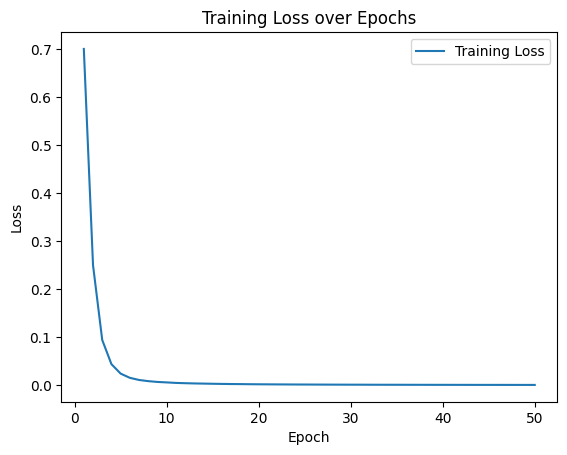



Accuracy on test set: 97.22%

Sample evaluation results:
Actual: 0, Predicted: 0
Actual: 2, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 2, Predicted: 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [16]:
# Train and evaluate using different optimizers and loss functions
# This loop resets the model for each optimizer and trains it from scratch

dataloaders = create_dataloaders(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, batch_size)
train_loader = dataloaders[0]
test_loader = dataloaders[1]

# Instantiate a new model for each optimizer, create the optimizer, train the model, and evaluate the model
for name in optimizer_names:

    print('-' * 200)
    print('-' * 200)

    # Instantiate model
    model = WineClassifier(input_dim, hidden_dim, output_dim).to(device)

    # Create Optimizer
    optimizer = get_optimizer(name, model, learning_rate=learning_rate)
    print(f"Created {name} optimizer: {optimizer}")

    # Train Model
    print(f"Training {model}")
    train_model(model, train_loader, criterion, optimizer, num_epochs)

    #Evaluate Model
    print(f"\n")
    evaluate_model(model, test_loader, 10)

    print('-' * 200)
    print('-' * 200)

# Student Work

## Part 1: Implement Additional Optimizers

1. Use the code provided to implement and test **two** new optimizers. (Add the dictionary key to the "optimizer_names" list). The provided optimizers are just a sample of the ones available in PyTorch. For a complete list see the official [PyTorch Documentation](https://pytorch.org/docs/stable/optim.html).

In [22]:
# PRACTICAL CODE GOES HERE!

#maybe change the name before submitting, so that they make sense
# Use this list to house the names of your optimizers.
optimizer_names = ["Abracadabra", "R-Pop"]

# Create your optimizers dynamically by defining them as lambda function.
def get_optimizer(name, model, learning_rate):
    optimizers = {
        "Abracadabra": lambda: optim.Adagrad(model.parameters(), lr=learning_rate),
        "R-Pop": lambda: optim.Rprop(model.parameters(), lr=learning_rate),

        "SGD": lambda: optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        "RMSprop": lambda: optim.RMSprop(model.parameters(), lr=learning_rate),
        "AdamW": lambda: optim.AdamW(model.parameters(), lr=learning_rate),
        "ASGD": lambda: optim.ASGD(model.parameters(), lr=learning_rate)
    }
    return optimizers.get(name, lambda: None)()  # Returns None if name is invalid

2. Provide a brief descripiton of each new optimizer algorithm you chose.

    Answer:

    *   R-prop : faster backpropagation algorithm
    *  Adagrad : adaptive subgradient

3. Train the `WineClassifier` model with each of your selected optimizers. Display the training loss graphs and test set performance. You should be able to use the same training and testing loop given in the example as a guide. Make sure to account for any variations to the learning rate you may have implemented.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Created Abracadabra optimizer: Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    fused: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)
Training WineClassifier(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)
Epoch [10/50], Loss: 0.1602
Epoch [20/50], Loss: 0.0827
Epoch [30/50], Loss: 0.0557
Epoch [40/50], Loss: 0.0421
Epoch [50/50], Loss: 0.0330


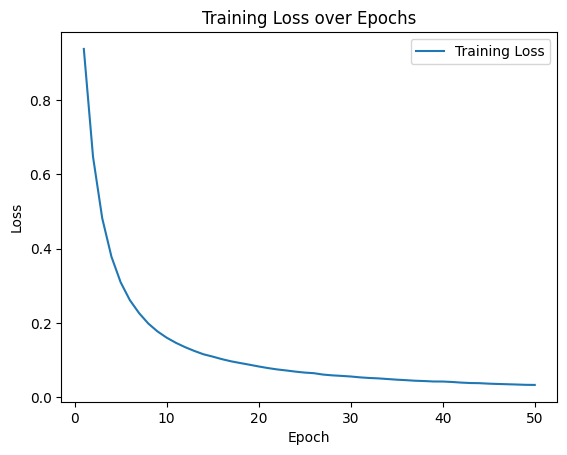



Accuracy on test set: 94.44%

Sample evaluation results:
Actual: 0, Predicted: 0
Actual: 2, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 2, Predicted: 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------

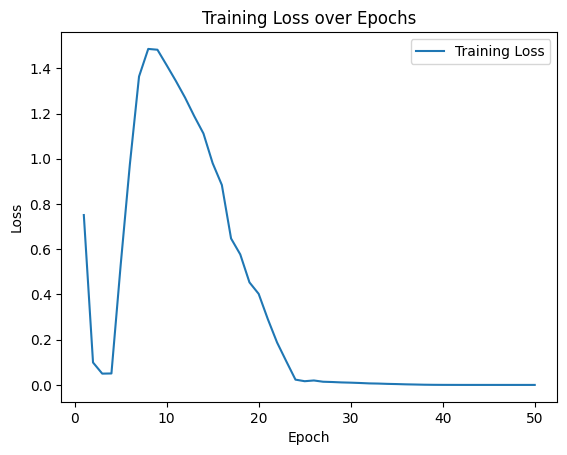



Accuracy on test set: 94.44%

Sample evaluation results:
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 2, Predicted: 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
# PRACTICAL CODE GOES HERE!
learninrg_rate = 0.001

# Instantiate a new model for each optimizer, create the optimizer, train the model, and evaluate the model
for name in optimizer_names:
    print('-' * 200)
    print('-' * 200)

    # Instantiate model
    model = WineClassifier(input_dim, hidden_dim, output_dim).to(device)

    # Create Optimizer
    optimizer = get_optimizer(name, model, learning_rate=learning_rate)
    print(f"Created {name} optimizer: {optimizer}")

    # Train Model
    print(f"Training {model}")
    train_model(model, train_loader, criterion, optimizer, num_epochs)

    #Evaluate Model
    print(f"\n")
    evaluate_model(model, test_loader, 10)

    print('-' * 200)
    print('-' * 200)

4. Do you see any performance difference during training or testing between the various optimizers? How do they compare to the `Adam` optimizer results?

    Answer:

## Part 2: A Deeper Wine Classifer Network

5. Create a new Wine Classifier network. Include the following:

   *  Three fully connected layers
   *  Two dropout layers

In [ ]:
# PRACTICAL CODE GOES HERE!

# Create a new Wine Classifer model

class WineClassifier2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.1):
        super(WineClassifier2, self).__init__()

        self.fc1 =  # First fully connected layer
        self.relu =  # Activation function (ReLU helps introduce non-linearity)
        self.dropout1 =  # Dropout layer that randomly sets a certain percentage of neurons to 0 during training

        self.fc2 =   # Second Fully Connected layer
        self.relu2 =  # Activation function (ReLU helps introduce non-linearity)
        self.dropout2 =  # Dropout layer that randomly sets a certain percentage of neurons to 0 during training

        self.fc3 = # Output Layer

    def forward(self, x):
        x =  # Apply first layer and activation
        x =  # Apply dropout

        x =  # Apply second layer and activation
        x =  # Apply dropout

        x =  # Output layer (raw logits)

        return x

6. Train and test the new model with the `Adam` optimizer and the **two** optimizers you chose to implement.

   Display the training loss graphs and test set performance. You should be able to use the same training and testing loop given in the example as a guide.

   Reimplement or adjust hyperparameters as needed. Since you will be comparing the performance of this model to the original model it would be best to have the hyperparameters match.

In [ ]:
# PRACTICAL CODE GOES HERE!

# Use this list to house the names of your optimizers.
optimizer_names = ['Adam']

# Create your optimizers dynamically by defining them as lambda function.
def get_optimizer(name, model, learning_rate):
    optimizers = {
    }
    return optimizers.get(name, lambda: None)()  # Returns None if name is invalid

# Set model hyperparameters

input_dim =  # Number of features (13)
hidden_dim =  # Number of neurons in the hidden layer (adjustable hyperparameter)
output_dim =  # Number of unique wine classes (3)
num_epochs =  # The number of times the model will pass through the dataset (adjustable hyperparameter)
batch_size =  # Number of images per training batch
learning_rate =  # Speed at which the model learns
dropout_rate =  # Percentage of neurons to drop during training

# Instantiate a new model for each optimizer, create the optimizer, train the model, and evaluate the model
for name in optimizer_names:


7. Do you see any performance difference during training or testing between the the two models? How do the same optimizers perform for each model? What could be the reason for better or worse performance. Is it what you expected?

    Answer:

## Part 3: Testing a Different Loss Function

8. Use the original Wine Classifer as a guide to create a third Wine Classifer. This time create the model such that it can be used with negative log likelihood loss (`NLLLoss`).

   [NLLLoss PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)

   Hint: You'll need to implement a new activation funciton for it to work properly.

In [ ]:
# PRACTICAL CODE GOES HERE!

# Implement Negative Log Likelihood Loss (NNLLLoss) here
criterion =

# Create a Wine Classifer model that uses NNLLLoss
class WineClassifier3(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WineClassifier3, self).__init__()


    def forward(self, x):

        return x

9. Train and test the new model with all three of the optimizer you implemented.

Display the training loss graphs and test set performance. You should be able to use the same or very similar training and testing loop given in the example as a guide.

In [ ]:
# PRACTICAL CODE GOES HERE!

# Set model hyperparameters

input_dim = # Number of features (13)
hidden_dim = # Number of neurons in the hidden layer (adjustable hyperparameter)
output_dim = # Number of unique wine classes (3)
num_epochs =  # The number of times the model will pass through the dataset (adjustable hyperparameter)
batch_size =  # Number of images per training batch
learning_rate = # Speed at which the model learns

# Instantiate a new model for each optimizer, create the optimizer, train the model, and evaluate the model
for name in optimizer_names:

10. Why did you need to add to the model in order to implement the NLLLoss? How does it perform in comparison to Cross-entropy Loss? What are some of the possible reasons for your observations?

    Answer: